Họ và tên: Phạm Đức Thể

MSSV: 19522253

Lớp: DS201.M11.2

Buổi 06 - 08/12/2021

# LAB 06 - ỨNG DỤNG MẠNG NEURAL HỒI QUY

## Bài toán phân tích cảm xúc (sentiment analysis)

### Setup

In [ ]:
# Check GPU
!nvidia-smi

Fri Dec 10 08:31:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download công cụ tách từ vncorenlp

In [ ]:
!pip install vncorenlp

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=cd00465814f35c74406d0aa2d1a7ac5ded0763b5b78439888c9ecec22ae8d86d
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter 
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar 
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab 
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr 
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/ 
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/ 

--2021-12-10 08:31:54--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   141MB/s    in 0.2s    

2021-12-10 08:31:54 (141 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2021-12-10 08:31:55--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

#### Download bộ Word embedding PhoW2V

In [ ]:
!gdown --id 102-AO-5zKTi8_NHCNUaKurUxHnljy6wt
!unzip word2vec_vi_words_100dims.zip

Downloading...
From: https://drive.google.com/uc?id=102-AO-5zKTi8_NHCNUaKurUxHnljy6wt
To: /content/word2vec_vi_words_100dims.zip
100% 786M/786M [00:05<00:00, 139MB/s]
Archive:  word2vec_vi_words_100dims.zip
  inflating: word2vec_vi_words_100dims.txt  


#### Import các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn


from vncorenlp import VnCoreNLP
from keras.models import Model, Input, Sequential
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score, confusion_matrix
from keras.layers import Flatten, Dense, Dropout
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

sn.set() # Set theme

#### Chuẩn bị dữ liệu

In [ ]:
path = '/content/drive/MyDrive/Dataset/UIT-VSFC'
# Train set
X_train = pd.read_csv(path + '/train/sents.txt',  sep='\n', 
                      header=None, index_col=None)
X_train = X_train.iloc[:, 0]
y_train = pd.read_csv(path + '/train/sentiments.txt',  sep='\n', 
                      header=None, index_col=None)
# Dev set
X_dev = pd.read_csv(path + '/dev/sents.txt', sep='\n', 
                    header=None, index_col=None)
X_dev = X_dev.iloc[:, 0]
y_dev = pd.read_csv(path + '/dev/sentiments.txt', sep='\n', 
                    header=None, index_col=None)
# Test set
X_test = pd.read_csv(path + '/test/sents.txt',  sep='\n', 
                     header=None, index_col=None)
X_test = X_test.iloc[:, 0]
y_test = pd.read_csv(path + '/test/sentiments.txt',  sep='\n', 
                     header=None, index_col=None)
# Flatten labels
y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()

#### Load bộ word-embedding lên

In [ ]:
EMBEDDING = '/content/word2vec_vi_words_100dims.txt' 
EMBEDING_DIM = 100 
MAX_FEATURE = 10000 
 
word_dict = [] 
embeddings_index = {} 
embedding_dim = EMBEDING_DIM 
max_feature = MAX_FEATURE 
 
f = open(EMBEDDING) 
for line in f: 
  values = line.split(' ') 
  word = values[0]  
  word_dict.append(word) 
  try: 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs 
  except Exception as e: 
    pass 
f.close() 
 
print('Embedding data loaded') 

Embedding data loaded


#### Xây dựng bộ từ vựng

In [ ]:
words = word_dict 
num_words = len(words) 
 
# Dictionary word:index pair 
# word is key and its value is corresponding index 
word2index = {w : i + 2 for i, w in enumerate(words)} 
word2index["UNK"] = 1 
word2index["PAD"] = 0 

# Dictionary lable:index pair 
idx2word = {i: w for w, i in word2index.items()}

#### Khởi tạo embedding matrix và load trọng số của pre-trained embedding vào

In [ ]:
embedding_matrix = np.zeros((num_words, embedding_dim)) 
 
# for each word in out tokenizer lets try to find that work in our w2v model 
for word, i in word2index.items(): 
  if i > max_feature: 
    continue 
  embedding_vector = embeddings_index.get(word) 
  if embedding_vector is not None: 
    # add that words vector to the matrix 
    embedding_matrix[i] = embedding_vector 
  else: 
    # doesn't exist, assign a random vector 
    embedding_matrix[i] = np.random.randn(embedding_dim)

#### Sử dụng bộ tách từ vncorenlp

In [ ]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", 
                      annotators="wseg", max_heap_size='-Xmx500m') 
 
def custom_tokenizer(text_data, tokenizer=True):
  if tokenizer: 
    return " ".join(vncorenlp.tokenize(str(text_data))[0]) 
  return text_data 

#### Tiến hành xây dựng hàm mã hoá cho các câu bình luận

In [ ]:
MAX_LEN = 100 
NUM_LABEL = 3 
TOKENIZER = True 

def encoding(X, y): 
  sentences = [] 
  for t in X: 
    sentences.append(custom_tokenizer(t,tokenizer=TOKENIZER)) 
  
  X = [] 
  for s in sentences: 
    sent = [] 
    for w in s.split(): 
      try: 
        w = w.lower() 
        sent.append(word2index[w]) 
      except: 
        sent.append(word2index["UNK"]) 
    X.append(sent) 
            
  X = pad_sequences(maxlen = MAX_LEN, sequences = X, 
                    padding = "post", value = word2index["PAD"]) 
  y = to_categorical(y, num_classes=NUM_LABEL) 
 
  return (X,y)

#### Tiến hành mã hoá dữ liệu ban đầu

In [ ]:
X_train_encoded, y_train_encoded = encoding(X_train.values.flatten(), y_train) 
X_dev_encoded, y_dev_encoded = encoding(X_dev.values.flatten(), y_dev) 
X_test_encoded, y_test_encoded = encoding(X_test.values.flatten(), y_test)

### Bài 1:

Hiện thực lại mô hình BiLSTM ở mục 1. Sử dụng các độ đo precision, recall và 
F1-score để cho biết khả năng dự đoán của mô hình. Đánh giá khả năng dự đoán của mô hình trên từng nhãn (confusion matrix). 


#### Xây dựng model

In [ ]:
model_1 = Sequential() 
model_1.add(Input(shape=(MAX_LEN, ), dtype="float64")) 
model_1.add(Embedding(input_dim=num_words, 
                      output_dim=embedding_dim, 
                      embeddings_initializer=Constant(embedding_matrix), 
                      input_length=MAX_LEN, 
                      trainable=False))
model_1.add(Bidirectional(LSTM(200,return_sequences=False))) 
model_1.add(Dense(3, activation='softmax')) 

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          158750800 
                                                                 
 bidirectional (Bidirectiona  (None, 400)              481600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 1203      
                                                                 
Total params: 159,233,603
Trainable params: 482,803
Non-trainable params: 158,750,800
_________________________________________________________________


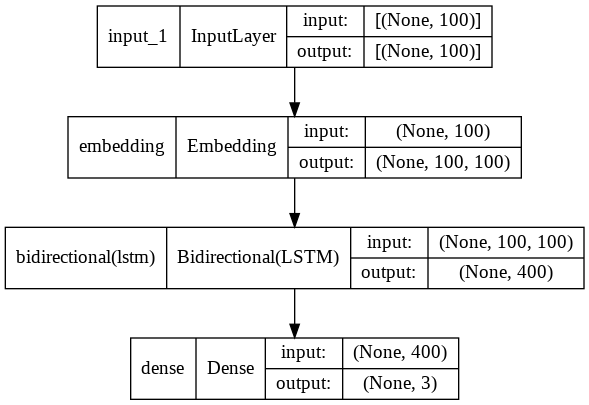

In [ ]:
tf.keras.utils.plot_model(model_1, to_file="model_1.png", show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = Adam(learning_rate=0.01) 
loss = CategoricalCrossentropy() 
callback = EarlyStopping(monitor='val_loss', patience=3)
model_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#### Training model

In [ ]:
# Training model
history_1 = model_1.fit(X_train_encoded, y_train_encoded,
                        validation_data=(X_dev_encoded, y_dev_encoded), 
                        batch_size=128, epochs=30, callbacks=[callback])

Epoch 1/30
90/90 [==============================] - 14s 82ms/step - loss: 0.6150 - accuracy: 0.7400 - val_loss: 0.4439 - val_accuracy: 0.8358
Epoch 2/30
90/90 [==============================] - 6s 70ms/step - loss: 0.3941 - accuracy: 0.8545 - val_loss: 0.3477 - val_accuracy: 0.8743
Epoch 3/30
90/90 [==============================] - 6s 70ms/step - loss: 0.3172 - accuracy: 0.8856 - val_loss: 0.3127 - val_accuracy: 0.8970
Epoch 4/30
90/90 [==============================] - 6s 70ms/step - loss: 0.2872 - accuracy: 0.9007 - val_loss: 0.3060 - val_accuracy: 0.8913
Epoch 5/30
90/90 [==============================] - 6s 70ms/step - loss: 0.2599 - accuracy: 0.9092 - val_loss: 0.2749 - val_accuracy: 0.9090
Epoch 6/30
90/90 [==============================] - 6s 70ms/step - loss: 0.2347 - accuracy: 0.9197 - val_loss: 0.2688 - val_accuracy: 0.9052
Epoch 7/30
90/90 [==============================] - 6s 70ms/step - loss: 0.2094 - accuracy: 0.9285 - val_loss: 0.2729 - val_accuracy: 0.9090
Epoch 8/30
9

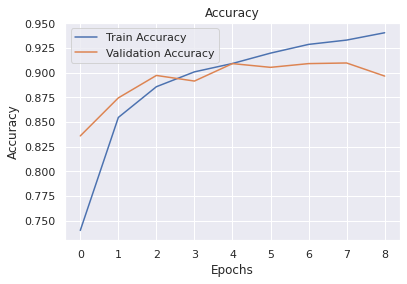

In [ ]:
plt.plot(history_1.history['accuracy'], label = 'Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

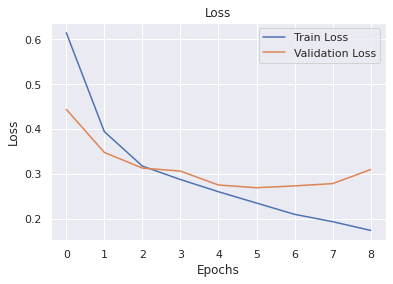

In [ ]:
plt.plot(history_1.history['loss'], label = 'Train Loss')
plt.plot(history_1.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict

In [ ]:
y_pred = model_1.predict(X_test_encoded)
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
precision = round(precision_score(y_test, y_pred, average='macro')*100, 2)
print('Precision macro test set: {}%'.format(precision))
precision = round(precision_score(y_test, y_pred, average='micro')*100, 2)
print('Precision micro test set: {}%'.format(precision))
recall = round(recall_score(y_test, y_pred, average='macro')*100, 2)
print('Recall macro test set: {}%'.format(recall))
recall = round(recall_score(y_test, y_pred, average='micro')*100, 2)
print('Recall micro test set: {}%'.format(recall))
f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
print('F1-score macro test set: {}%'.format(f1))
f1 = round(f1_score(y_test, y_pred, average='micro')*100, 2)
print('F1-score micro test set: {}%'.format(f1))

Precision macro test set: 76.68%
Precision micro test set: 88.38%
Recall macro test set: 72.24%
Recall micro test set: 88.38%
F1-score macro test set: 73.81%
F1-score micro test set: 88.38%


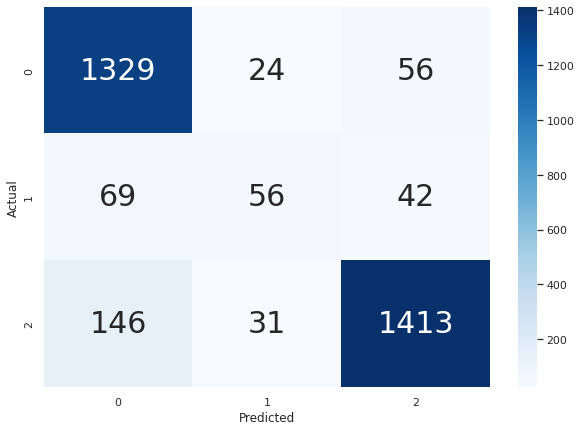

In [ ]:
# Visualization confusion matrix of test set
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, cmap = 'Blues', fmt='g', 
           cbar=True, annot_kws={"size": 30})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Save model

In [ ]:
# model_1.save('/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS201.M11 - DEEP LEARNING TRONG KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB06 08 12 2021/model_bai1.h5')

### Bài 2:

Giống bài 1, nhưng sử dụng 2 lớp BiLSTM kết hợp nhau. So sánh 2 mô hình với nhau và cho biết kết quả.


#### Xây dựng model

In [ ]:
model_2 = Sequential() 
model_2.add(Input(shape=(MAX_LEN, ), dtype="float64")) 
model_2.add(Embedding(input_dim=num_words, 
                      output_dim=embedding_dim, 
                      embeddings_initializer=Constant(embedding_matrix), 
                      input_length=MAX_LEN, 
                      trainable=False)) 
model_2.add(Bidirectional(LSTM(200,return_sequences=True))) 
model_2.add(Bidirectional(LSTM(100,return_sequences=False)))
model_2.add(Dense(3, activation='softmax')) 

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          158750800 
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 400)         481600    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              400800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 159,633,803
Trainable params: 883,003
Non-trainable params: 158,750,800
_________________________________________________________________


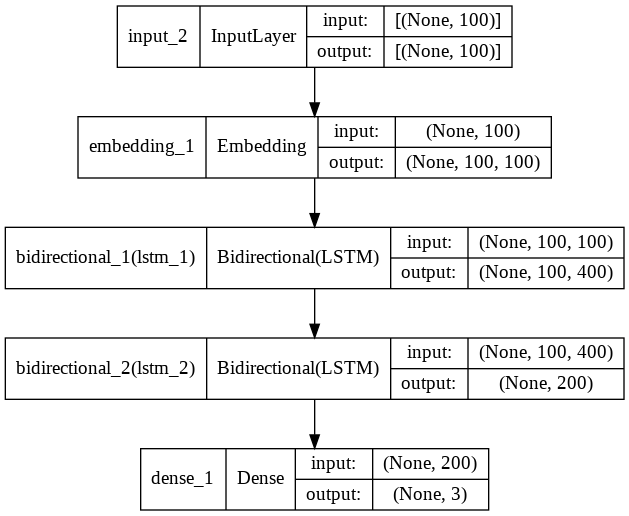

In [ ]:
tf.keras.utils.plot_model(model_2, to_file="model_2.png", show_shapes=True, show_layer_names=True,)

In [ ]:
optimizer = Adam(learning_rate=0.01) 
loss = CategoricalCrossentropy() 
callback = EarlyStopping(monitor='val_loss', patience=3)
model_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#### Training model

In [ ]:
# Training model
history_2 = model_2.fit(X_train_encoded, y_train_encoded,
                        validation_data=(X_dev_encoded, y_dev_encoded), 
                        batch_size=128, epochs=30, callbacks=[callback])

Epoch 1/30
90/90 [==============================] - 21s 153ms/step - loss: 0.6273 - accuracy: 0.7363 - val_loss: 0.5282 - val_accuracy: 0.7808
Epoch 2/30
90/90 [==============================] - 12s 134ms/step - loss: 0.3880 - accuracy: 0.8636 - val_loss: 0.3594 - val_accuracy: 0.8756
Epoch 3/30
90/90 [==============================] - 12s 134ms/step - loss: 0.3256 - accuracy: 0.8860 - val_loss: 0.3083 - val_accuracy: 0.8913
Epoch 4/30
90/90 [==============================] - 12s 134ms/step - loss: 0.2890 - accuracy: 0.8980 - val_loss: 0.2925 - val_accuracy: 0.8964
Epoch 5/30
90/90 [==============================] - 12s 133ms/step - loss: 0.2595 - accuracy: 0.9106 - val_loss: 0.2843 - val_accuracy: 0.9090
Epoch 6/30
90/90 [==============================] - 12s 134ms/step - loss: 0.2382 - accuracy: 0.9187 - val_loss: 0.2670 - val_accuracy: 0.9141
Epoch 7/30
90/90 [==============================] - 12s 133ms/step - loss: 0.2239 - accuracy: 0.9237 - val_loss: 0.2642 - val_accuracy: 0.9097

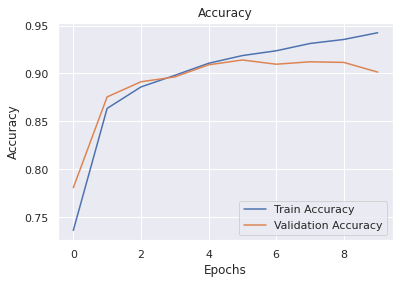

In [ ]:
plt.plot(history_2.history['accuracy'], label = 'Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

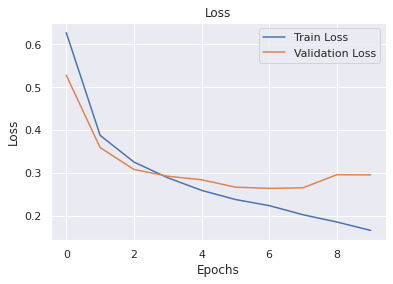

In [ ]:
plt.plot(history_2.history['loss'], label = 'Train Loss')
plt.plot(history_2.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict

In [ ]:
y_pred = model_2.predict(X_test_encoded)
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
precision = round(precision_score(y_test, y_pred, average='macro')*100, 2)
print('Precision macro test set: {}%'.format(precision))
precision = round(precision_score(y_test, y_pred, average='micro')*100, 2)
print('Precision micro test set: {}%'.format(precision))
recall = round(recall_score(y_test, y_pred, average='macro')*100, 2)
print('Recall macro test set: {}%'.format(recall))
recall = round(recall_score(y_test, y_pred, average='micro')*100, 2)
print('Recall micro test set: {}%'.format(recall))
f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
print('F1-score macro test set: {}%'.format(f1))
f1 = round(f1_score(y_test, y_pred, average='micro')*100, 2)
print('F1-score micro test set: {}%'.format(f1))

Precision macro test set: 81.2%
Precision micro test set: 89.23%
Recall macro test set: 73.7%
Recall micro test set: 89.23%
F1-score macro test set: 76.17%
F1-score micro test set: 89.23%


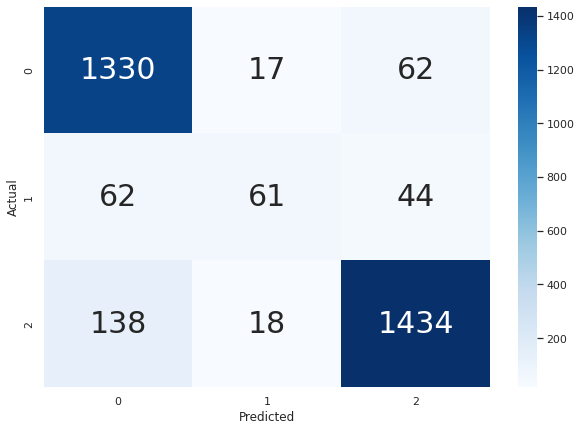

In [ ]:
# Visualization confusion matrix of test set
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, cmap = 'Blues', fmt='g', cbar=True, annot_kws={"size": 30})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Save model

In [ ]:
# model_2.save('/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS201.M11 - DEEP LEARNING TRONG KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB06 08 12 2021/model_bai2.h5')

## Bài toán nhận diện thực thể có tên (named entities recognition)

### Setup

In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=f74ccbf9a7e6a487d2f0e17fb5c540b0b57996a2a465bb534e8d7675b678a6bf
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


#### Download bộ dữ liệu

In [ ]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 44 (delta 14), reused 30 (delta 12), pack-reused 0
Unpacking objects: 100% (44/44), done.


#### Đọc dữ liệu

In [ ]:
def load_data_and_labels(filename, encoding='utf-8'): 
  sents, labels = [], [] 
  words, tags = [], [] 
  with open(filename, encoding=encoding) as f: 
    for line in f: 
      try: 
        line = line.strip() 
        if line: 
          word, tag = line.split(" ") 
          words.append(word) 
          tags.append(tag) 
        else: 
          sents.append(words) 
          labels.append(tags) 
          words, tags = [], [] 
      except Exception as e: 
        pass
  return sents, labels 
 
train_set_word = load_data_and_labels('/content/PhoNER_COVID19/data/word/train_word.conll') 
dev_set_word = load_data_and_labels('/content/PhoNER_COVID19/data/word/dev_word.conll')  
test_set_word = load_data_and_labels('/content/PhoNER_COVID19/data/word/test_word.conll') 

#### Load bộ word-embedding lên

In [ ]:
EMBEDDING = '/content/word2vec_vi_words_100dims.txt' 
EMBEDING_DIM = 100 
MAX_FEATURE = 10000 
MAX_LEN = 100 

word_dict = [] 
embeddings_index_word = {} 
embedding_dim = EMBEDING_DIM 
max_feature = MAX_FEATURE 
 
f = open(EMBEDDING) 
for line in f: 
  values = line.split(' ') 
  word = values[0]  
  word_dict.append(word) 
  try: 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index_word[word] = coefs 
  except Exception as e: 
    pass 
f.close() 
 
print('Embedding data loaded') 

Embedding data loaded


#### Lấy ra bộ nhãn (tags)

In [ ]:
tags = list(set(np.concatenate((np.concatenate(train_set_word[1]), np.concatenate(dev_set_word[1])))))

#### Xây dựng word_index và tag_index

In [ ]:
words = word_dict 
num_words = len(words) 

words2index = {w:i for i,w in enumerate(words)} 
tags2index = {t:i for i,t in enumerate(tags)}

#### Khởi tạo embedding matrix và load trọng số của pre-trained embedding vào

In [ ]:
embedding_matrix_word = np.zeros((num_words, embedding_dim)) 
 
# for each word in out tokenizer lets try to find that work in our w2v model 
for word, i in words2index.items(): 
  if i > max_feature: 
    continue 
  embedding_word_vector = embeddings_index_word.get(word) 
  if embedding_word_vector is not None: 
    # add that words vector to the matrix 
    embedding_matrix_word[i] = embedding_word_vector 
  else: 
    # doesn't exist, assign a random vector 
    embedding_matrix_word[i] = np.random.randn(embedding_dim)

#### Mã hoá dữ liệu

In [ ]:
def encoding(data): 
  X = [[words2index.get(w, 0) for w in t] for t in data[0]] 
  X = pad_sequences(maxlen = MAX_LEN, sequences = X, 
                    padding = "post", value = 0) 

  y = [[tags2index[w] for w in s] for s in data[1]] 
  y = pad_sequences(maxlen=MAX_LEN, sequences=y, 
                    padding="post", value=tags2index["O"]) 

  return X, y 
 
X_train_word, y_train_word = encoding(train_set_word) 
X_dev_word, y_dev_word = encoding(dev_set_word) 
X_test_word, y_test_word = encoding(test_set_word) 

 
y_train_word = to_categorical(y_train_word, num_classes=len(tags)) 
y_dev_word = to_categorical(y_dev_word, num_classes=len(tags)) 

### Bài 3: 

Hiện thực lại mô hình BiLSTM cho tác vụ NER trên bộ dữ liệu COVID-19 NER ở mức độ từ (word-level). 



#### Xây dựng model

In [ ]:
model_3 = Sequential() 
model_3.add(Input(shape=(MAX_LEN,)))
model_3.add(Embedding(input_dim = num_words,  
                      output_dim = EMBEDING_DIM, 
                      embeddings_initializer=Constant(embedding_matrix_word), 
                      input_length = MAX_LEN, 
                      mask_zero = True, 
                      trainable=False)) 
model_3.add(Bidirectional(LSTM(units=200,return_sequences=True, 
                             recurrent_dropout=0.2, dropout=0.2))) 
model_3.add(TimeDistributed(Dense(len(tags), activation="softmax"))) 

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          158750800 
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 400)         481600    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 100, 20)          8020      
 ibuted)                                                         
                                                                 
Total params: 159,240,420
Trainable params: 489,620
Non-trainable params: 158,750,800
_________________________________________________________________


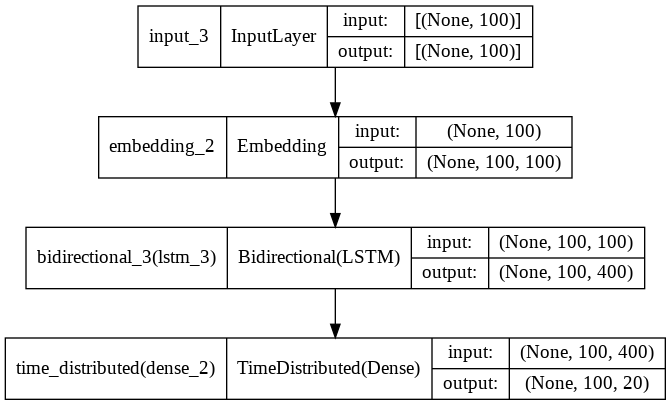

In [ ]:
tf.keras.utils.plot_model(model_3, to_file="model_3.png", show_shapes=True, show_layer_names=True,)

In [ ]:
optimizer = Adam(learning_rate=0.01) 
loss = CategoricalCrossentropy() 
callback = EarlyStopping(monitor='val_loss', patience=3)
model_3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) 

#### Training model

In [ ]:
# Training model
history_3 = model_3.fit(X_train_word, y_train_word,
                        validation_data=(X_dev_word, y_dev_word),
                        batch_size=128, epochs=30,
                        callbacks=[callback])

Epoch 1/30
40/40 [==============================] - 72s 2s/step - loss: 0.2750 - accuracy: 0.7730 - val_loss: 0.2482 - val_accuracy: 0.7554
Epoch 2/30
40/40 [==============================] - 64s 2s/step - loss: 0.1414 - accuracy: 0.8490 - val_loss: 0.1147 - val_accuracy: 0.8748
Epoch 3/30
40/40 [==============================] - 63s 2s/step - loss: 0.0731 - accuracy: 0.9165 - val_loss: 0.0780 - val_accuracy: 0.9166
Epoch 4/30
40/40 [==============================] - 62s 2s/step - loss: 0.0528 - accuracy: 0.9391 - val_loss: 0.0650 - val_accuracy: 0.9292
Epoch 5/30
40/40 [==============================] - 63s 2s/step - loss: 0.0430 - accuracy: 0.9492 - val_loss: 0.0613 - val_accuracy: 0.9312
Epoch 6/30
40/40 [==============================] - 62s 2s/step - loss: 0.0386 - accuracy: 0.9546 - val_loss: 0.0481 - val_accuracy: 0.9456
Epoch 7/30
40/40 [==============================] - 62s 2s/step - loss: 0.0337 - accuracy: 0.9596 - val_loss: 0.0502 - val_accuracy: 0.9432
Epoch 8/30
40/40 [==

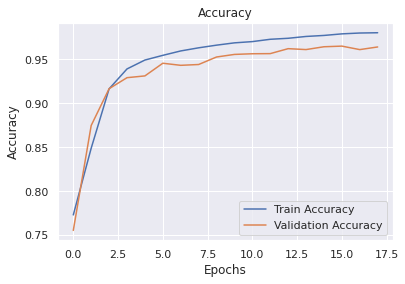

In [ ]:
plt.plot(history_3.history['accuracy'], label = 'Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

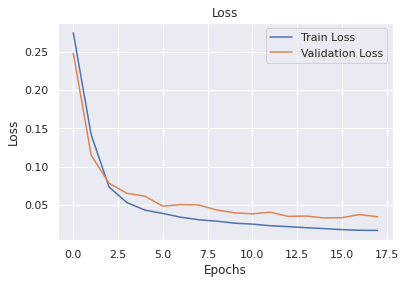

In [ ]:
plt.plot(history_3.history['loss'], label = 'Train Loss')
plt.plot(history_3.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict

In [ ]:
y_true = []
y_pred = []
for i in range(y_test_word.shape[0]):
  y_true.append(y_test_word[i])
  p = model_3.predict(np.array([X_test_word[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [ ]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags[y_true[i][k]])
    pred.append(tags[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [ ]:
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test set: {}%'.format(accuracy))
f1 = round(f1_score(Y_true, Y_pred, average='micro')*100,2)
print('F1-score micro test set: {}%'.format(f1))
f1 = round(f1_score(Y_true, Y_pred, average='macro')*100,2)
print('F1-score macro test set: {}%'.format(f1))

Accuracy test set: 98.67%
F1-score micro test set: 85.06%
F1-score macro test set: 75.43%


In [ ]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

                     precision    recall  f1-score   support

                AGE     0.9662    0.8970    0.9303       573
               DATE     0.9627    0.9697    0.9662      1650
             GENDER     0.9846    0.8477    0.9110       453
                JOB     0.5606    0.4302    0.4868       172
           LOCATION     0.8467    0.8509    0.8488      4434
               NAME     0.8207    0.4748    0.6016       318
       ORGANIZATION     0.6283    0.7017    0.6630       771
         PATIENT_ID     0.9432    0.9488    0.9460      1994
SYMPTOM_AND_DISEASE     0.7592    0.7245    0.7414      1136
     TRANSPORTATION     0.8788    0.3005    0.4479       193

          micro avg     0.8626    0.8389    0.8506     11694
          macro avg     0.8351    0.7146    0.7543     11694
       weighted avg     0.8634    0.8389    0.8470     11694



#### Save model

In [ ]:
# model_3.save('/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS201.M11 - DEEP LEARNING TRONG KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB06 08 12 2021/model_bai3.h5')

### Bài 4: 

Tương tự bài 3, nhưng sử dụng bộ dữ liệu COVID-19 NER trên mức độ tiếng (syllabus). So sánh kết quả giữa 2 loại mức độ từ và mức độ tiếng.



#### Chuẩn bị dữ liệu

##### Download bộ Syllables embedding PhoW2V

In [ ]:
!gdown --id 1yj4-YPJ33Nck2GbKshxgM28PeT-mqyC6
!unzip word2vec_vi_syllables_100dims.zip

Downloading...
From: https://drive.google.com/uc?id=1yj4-YPJ33Nck2GbKshxgM28PeT-mqyC6
To: /content/word2vec_vi_syllables_100dims.zip
100% 480M/480M [00:12<00:00, 38.8MB/s]
Archive:  word2vec_vi_syllables_100dims.zip
  inflating: word2vec_vi_syllables_100dims.txt  


##### Load bộ syllables-embedding lên

In [ ]:
EMBEDDING = '/content/word2vec_vi_syllables_100dims.txt' 
EMBEDING_DIM = 100 
MAX_FEATURE = 10000 
MAX_LEN = 100 

syllable_dict = [] 
embeddings_index_syllable = {} 
embedding_dim = EMBEDING_DIM 
max_feature = MAX_FEATURE 
 
f = open(EMBEDDING) 
for line in f: 
  values = line.split(' ') 
  syllable = values[0]  
  syllable_dict.append(syllable) 
  try: 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index_syllable[syllable] = coefs 
  except Exception as e: 
    pass 
f.close() 
 
print('Embedding data loaded') 

Embedding data loaded


##### Đọc dữ liệu

In [ ]:
def load_data_and_labels(filename, encoding='utf-8'): 
  sents, labels = [], [] 
  syllables, tags = [], [] 
  with open(filename, encoding=encoding) as f: 
    for line in f: 
      try: 
        line = line.strip() 
        if line: 
          syllable, tag = line.split(" ") 
          syllables.append(syllable) 
          tags.append(tag) 
        else: 
          sents.append(syllables) 
          labels.append(tags) 
          syllables, tags = [], [] 
      except Exception as e: 
        pass
  return sents, labels 
 
train_set_syllable = load_data_and_labels('/content/PhoNER_COVID19/data/syllable/train_syllable.conll')
dev_set_syllable = load_data_and_labels('/content/PhoNER_COVID19/data/syllable/dev_syllable.conll') 
test_set_syllable = load_data_and_labels('/content/PhoNER_COVID19/data/syllable/test_syllable.conll') 

##### Lấy ra bộ nhãn (tags)

In [ ]:
tags_syllable = list(set(np.concatenate((
    np.concatenate(train_set_syllable[1]),
    np.concatenate(dev_set_syllable[1])))))

##### Xây dựng syllable_index và tag_syllable_index

In [ ]:
syllables = syllable_dict 
num_syllables = len(syllables) 

syllable2index = {w:i for i,w in enumerate(syllables)} 
tags_syllable2index = {t:i for i,t in enumerate(tags_syllable)}

##### Khởi tạo embedding matrix và load trọng số của pre-trained embedding vào

In [ ]:
embedding_matrix_syllable = np.zeros((num_syllables, embedding_dim)) 
 
# for each syllable in out tokenizer lets try to find that work in our s2v model 
for syllable, i in syllable2index.items(): 
  if i > max_feature: 
    continue 
  embedding_syllable_vector = embeddings_index_syllable.get(syllable) 
  if embedding_syllable_vector is not None: 
    # add that syllables vector to the matrix 
    embedding_matrix_syllable[i] = embedding_syllable_vector 
  else: 
    # doesn't exist, assign a random vector 
    embedding_matrix_syllable[i] = np.random.randn(embedding_dim)

##### Mã hoá dữ liệu

In [ ]:
def encoding(data): 
  X = [[syllable2index.get(w, 0) for w in t] for t in data[0]] 
  X = pad_sequences(maxlen = MAX_LEN, sequences = X, 
                    padding = "post", value = 0) 

  y = [[tags_syllable2index[w] for w in s] for s in data[1]] 
  y = pad_sequences(maxlen=MAX_LEN, sequences=y, 
                    padding="post", value=tags_syllable2index["O"]) 
 
  return X, y 
 
X_train_syllable, y_train_syllable = encoding(train_set_syllable) 
X_dev_syllable, y_dev_syllable = encoding(dev_set_syllable) 
X_test_syllable, y_test_syllable = encoding(test_set_syllable) 

 
y_train_syllable = to_categorical(y_train_syllable, 
                                  num_classes=len(tags_syllable)) 
y_dev_syllable = to_categorical(y_dev_syllable, 
                                num_classes=len(tags_syllable)) 

#### Xây dựng model

In [ ]:
model_4 = Sequential() 
model_4.add(Input(shape=(MAX_LEN,)))
model_4.add(Embedding(input_dim = num_syllables,  
                      output_dim = EMBEDING_DIM,
                      embeddings_initializer=Constant(embedding_matrix_syllable), 
                      input_length = MAX_LEN,  
                      mask_zero = True,  
                      trainable=False)) 
model_4.add(Bidirectional(LSTM(units=200,return_sequences=True, 
                             recurrent_dropout=0.2, dropout=0.2))) 
model_4.add(TimeDistributed(Dense(len(tags_syllable), activation="softmax"))) 

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          97946100  
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 400)         481600    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 21)          8421      
 tributed)                                                       
                                                                 
Total params: 98,436,121
Trainable params: 490,021
Non-trainable params: 97,946,100
_________________________________________________________________


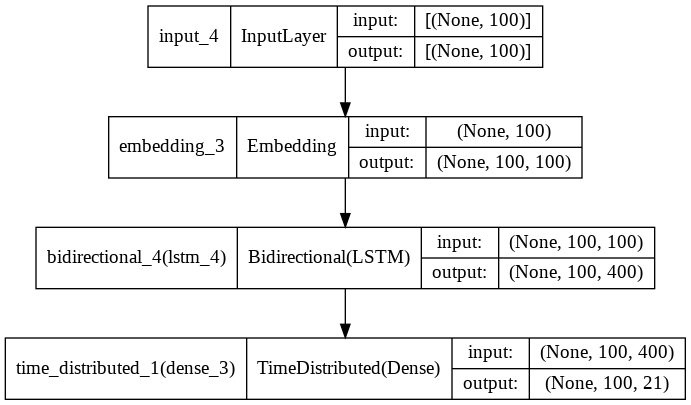

In [ ]:
tf.keras.utils.plot_model(model_4, to_file="model_4.png", show_shapes=True, show_layer_names=True,)

In [ ]:
optimizer = Adam(learning_rate=0.01) 
loss = CategoricalCrossentropy() 
callback = EarlyStopping(monitor='val_loss', patience=3)
model_4.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) 

#### Training model

In [ ]:
# Training model
history_4 = model_4.fit(X_train_syllable, y_train_syllable,
                        validation_data=(X_dev_syllable, y_dev_syllable),
                        batch_size=128, epochs=30,
                        callbacks=[callback])

Epoch 1/30
40/40 [==============================] - 73s 2s/step - loss: 0.3521 - accuracy: 0.7592 - val_loss: 0.3023 - val_accuracy: 0.7712
Epoch 2/30
40/40 [==============================] - 66s 2s/step - loss: 0.1886 - accuracy: 0.8411 - val_loss: 0.1818 - val_accuracy: 0.8393
Epoch 3/30
40/40 [==============================] - 66s 2s/step - loss: 0.1105 - accuracy: 0.8974 - val_loss: 0.1390 - val_accuracy: 0.8778
Epoch 4/30
40/40 [==============================] - 65s 2s/step - loss: 0.0867 - accuracy: 0.9210 - val_loss: 0.0979 - val_accuracy: 0.9152
Epoch 5/30
40/40 [==============================] - 64s 2s/step - loss: 0.0671 - accuracy: 0.9387 - val_loss: 0.0848 - val_accuracy: 0.9261
Epoch 6/30
40/40 [==============================] - 64s 2s/step - loss: 0.0579 - accuracy: 0.9464 - val_loss: 0.0833 - val_accuracy: 0.9259
Epoch 7/30
40/40 [==============================] - 65s 2s/step - loss: 0.0529 - accuracy: 0.9500 - val_loss: 0.0738 - val_accuracy: 0.9339
Epoch 8/30
40/40 [==

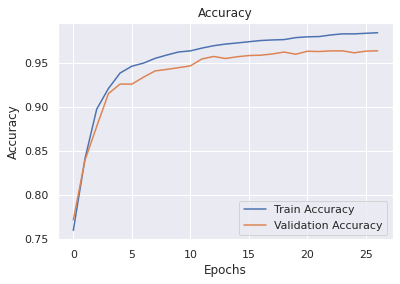

In [ ]:
plt.plot(history_4.history['accuracy'], label = 'Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

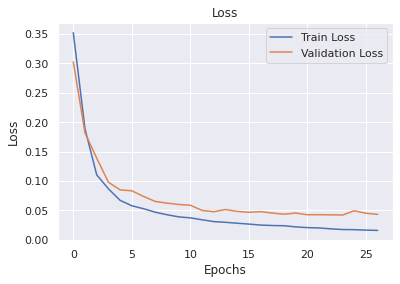

In [ ]:
plt.plot(history_4.history['loss'], label = 'Train Loss')
plt.plot(history_4.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict

In [ ]:
y_true = []
y_pred = []
for i in range(y_test_syllable.shape[0]):
  y_true.append(y_test_syllable[i])
  p = model_4.predict(np.array([X_test_syllable[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [ ]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags_syllable[y_true[i][k]])
    pred.append(tags_syllable[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [ ]:
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test set: {}%'.format(accuracy))
f1 = round(f1_score(Y_true, Y_pred, average='micro')*100,2)
print('F1-score micro test set: {}%'.format(f1))
f1 = round(f1_score(Y_true, Y_pred, average='macro')*100,2)
print('F1-score macro test set: {}%'.format(f1))

Accuracy test set: 98.44%
F1-score micro test set: 84.61%
F1-score macro test set: 75.86%


In [ ]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

                     precision    recall  f1-score   support

                AGE     0.9339    0.9421    0.9380       570
               DATE     0.9513    0.9739    0.9625      1645
             GENDER     0.9252    0.9087    0.9169       449
                JOB     0.5128    0.4651    0.4878       172
           LOCATION     0.8265    0.8648    0.8452      4429
               NAME     0.7055    0.6478    0.6754       318
       ORGANIZATION     0.5607    0.7022    0.6236       769
         PATIENT_ID     0.9560    0.9627    0.9593      1985
SYMPTOM_AND_DISEASE     0.7187    0.7218    0.7202      1136
     TRANSPORTATION     0.7949    0.3212    0.4576       193

          micro avg     0.8356    0.8568    0.8461     11666
          macro avg     0.7885    0.7510    0.7586     11666
       weighted avg     0.8387    0.8568    0.8454     11666



#### Save model

In [ ]:
# model_4.save('/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS201.M11 - DEEP LEARNING TRONG KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB06 08 12 2021/model_bai4.h5')

### Bài 5: 

Sử dụng 2 lớp BiLSTM kết hợp nhau trên bộ dữ liệu COVID-19 NER ở mức độ từ (word). 



#### Xây dựng model

In [ ]:
model_5 = Sequential() 
model_5.add(Input(shape=(MAX_LEN,)))
model_5.add(Embedding(input_dim = num_words,  
                      output_dim = EMBEDING_DIM, 
                      embeddings_initializer=Constant(embedding_matrix_word),  
                      input_length = MAX_LEN,  
                      mask_zero = True,  
                      trainable=False)) 
model_5.add(Bidirectional(LSTM(units=200,return_sequences=True, 
                               recurrent_dropout=0.2, dropout=0.2))) 
model_5.add(Bidirectional(LSTM(units=100,return_sequences=True, 
                               recurrent_dropout=0.2, dropout=0.2))) 
model_5.add(TimeDistributed(Dense(len(tags), activation="softmax"))) 

In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          158750800 
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 400)         481600    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 100, 200)         400800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 20)          4020      
 tributed)                                                       
                                                                 
Total params: 159,637,220
Trainable params: 886,420
Non-trainable params: 158,750,800
__________________________________

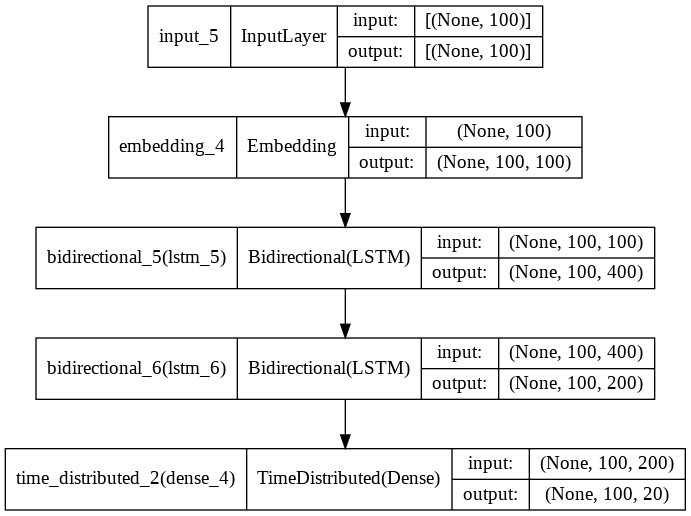

In [ ]:
tf.keras.utils.plot_model(model_5, to_file="model_5.png", show_shapes=True, show_layer_names=True,)

In [ ]:
optimizer = Adam(learning_rate=0.01) 
loss = CategoricalCrossentropy() 
callback = EarlyStopping(monitor='val_loss', patience=3)
model_5.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) 

#### Training model

In [ ]:
# Training model
history_5 = model_5.fit(X_train_word, y_train_word,
                        validation_data=(X_dev_word, y_dev_word),
                        batch_size=128, epochs=30,
                        callbacks=[callback])

Epoch 1/30
40/40 [==============================] - 143s 3s/step - loss: 0.2698 - accuracy: 0.7579 - val_loss: 0.2386 - val_accuracy: 0.7810
Epoch 2/30
40/40 [==============================] - 129s 3s/step - loss: 0.1395 - accuracy: 0.8527 - val_loss: 0.1150 - val_accuracy: 0.8831
Epoch 3/30
40/40 [==============================] - 130s 3s/step - loss: 0.0685 - accuracy: 0.9233 - val_loss: 0.0744 - val_accuracy: 0.9206
Epoch 4/30
40/40 [==============================] - 129s 3s/step - loss: 0.0463 - accuracy: 0.9477 - val_loss: 0.0642 - val_accuracy: 0.9320
Epoch 5/30
40/40 [==============================] - 131s 3s/step - loss: 0.0370 - accuracy: 0.9573 - val_loss: 0.0469 - val_accuracy: 0.9476
Epoch 6/30
40/40 [==============================] - 130s 3s/step - loss: 0.0310 - accuracy: 0.9631 - val_loss: 0.0440 - val_accuracy: 0.9520
Epoch 7/30
40/40 [==============================] - 131s 3s/step - loss: 0.0273 - accuracy: 0.9675 - val_loss: 0.0416 - val_accuracy: 0.9542
Epoch 8/30
40

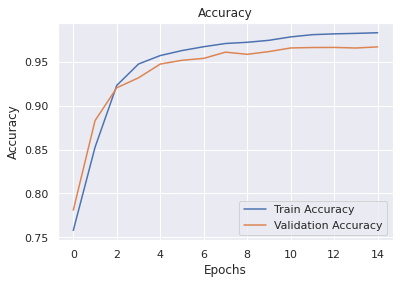

In [ ]:
plt.plot(history_5.history['accuracy'], label = 'Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

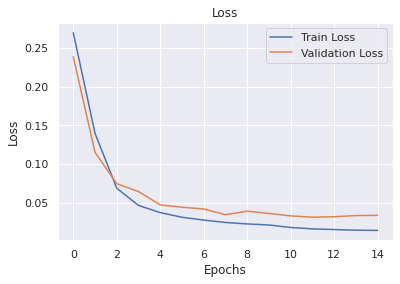

In [ ]:
plt.plot(history_5.history['loss'], label = 'Train Loss')
plt.plot(history_5.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predict

In [ ]:
y_true = []
y_pred = []
for i in range(y_test_word.shape[0]):
  y_true.append(y_test_word[i])
  p = model_5.predict(np.array([X_test_word[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [ ]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags[y_true[i][k]])
    pred.append(tags[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [ ]:
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test set: {}%'.format(accuracy))
f1 = round(f1_score(Y_true, Y_pred, average='micro')*100,2)
print('F1-score micro test set: {}%'.format(f1))
f1 = round(f1_score(Y_true, Y_pred, average='macro')*100,2)
print('F1-score macro test set: {}%'.format(f1))

Accuracy test set: 98.79%
F1-score micro test set: 86.11%
F1-score macro test set: 76.12%


In [ ]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

                     precision    recall  f1-score   support

                AGE     0.9067    0.9668    0.9358       573
               DATE     0.9626    0.9673    0.9649      1650
             GENDER     0.9071    0.9272    0.9170       453
                JOB     0.5263    0.5233    0.5248       172
           LOCATION     0.8547    0.8931    0.8735      4434
               NAME     0.7989    0.4497    0.5755       318
       ORGANIZATION     0.6605    0.6913    0.6755       771
         PATIENT_ID     0.9059    0.9604    0.9323      1994
SYMPTOM_AND_DISEASE     0.7728    0.7394    0.7557      1136
     TRANSPORTATION     0.9077    0.3057    0.4574       193

          micro avg     0.8577    0.8645    0.8611     11694
          macro avg     0.8203    0.7424    0.7612     11694
       weighted avg     0.8570    0.8645    0.8566     11694



#### Save model

In [ ]:
# model_5.save('/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS201.M11 - DEEP LEARNING TRONG KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB06 08 12 2021/model_bai5.h5')